## MoCo on CIFAR10 using CrossBatchMemory from [PyTorch Metric Learning](https://github.com/KevinMusgrave/pytorch-metric-learning)
Why use CrossBatchMemory?
- It separates the queue from the model (it's modular).
- You can easily use any tuple loss on the embeddings (not just InfoNCE / NTXent).
- You can optionally use any pair/triplet miner to extract hard samples from the momentum encoder queue.

After 200 epochs:

- This notebook's accuracy: 82.9%
- The [official MoCo repo's CIFAR10 notebook](https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb) accuracy: 82.6%

In [ ]:
!pip install -q pytorch-metric-learning[with-hooks]

# Creating the dataset and image transforms

In [ ]:
import logging
import os
import random
from functools import partial

import torch
from PIL import ImageFilter

##############################################################################
### Many parts of this are a modified version of the official MoCo code ######
############### https://github.com/facebookresearch/moco #####################
##############################################################################
from torchvision import datasets, transforms
from torchvision.models import resnet
from tqdm import tqdm

from pytorch_metric_learning import losses
from pytorch_metric_learning.utils import logging_presets

logging.getLogger().setLevel(logging.INFO)

device = torch.device("cuda")


######################
### from MoCo repo ###
######################
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


######################
### from MoCo repo ###
######################
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


######################
### from MoCo repo ###
######################
def create_dataset(batch_size):
    normalize = transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])

    train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            normalize,
        ]
    )

    train_transform = TwoCropsTransform(train_transform)

    val_transform = transforms.Compose([transforms.ToTensor(), normalize])

    train_dataset = datasets.CIFAR10(
        "dataset", train=True, download=True, transform=train_transform
    )
    train_dataset_for_eval = datasets.CIFAR10(
        "dataset", train=True, download=True, transform=val_transform
    )
    val_dataset = datasets.CIFAR10(
        "dataset", train=False, download=True, transform=val_transform
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    train_loader_for_eval = torch.utils.data.DataLoader(
        train_dataset_for_eval,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        drop_last=False,
    )

    return (
        train_dataset,
        train_dataset_for_eval,
        val_dataset,
        train_loader,
        train_loader_for_eval,
        val_loader,
    )

# Model definition and code for copying params from encQ to encK

In [ ]:
######################
### from MoCo repo ###
######################
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(torch.nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = torch.nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W),
                running_mean_split,
                running_var_split,
                self.weight.repeat(self.num_splits),
                self.bias.repeat(self.num_splits),
                True,
                self.momentum,
                self.eps,
            ).view(N, C, H, W)
            self.running_mean.data.copy_(
                running_mean_split.view(self.num_splits, C).mean(dim=0)
            )
            self.running_var.data.copy_(
                running_var_split.view(self.num_splits, C).mean(dim=0)
            )
            return outcome
        else:
            return torch.nn.functional.batch_norm(
                input,
                self.running_mean,
                self.running_var,
                self.weight,
                self.bias,
                False,
                self.momentum,
                self.eps,
            )


######################
### from MoCo repo ###
######################
class ModelBase(torch.nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """

    def __init__(self, feature_dim=128, arch="resnet18", bn_splits=8):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = (
            partial(SplitBatchNorm, num_splits=bn_splits)
            if bn_splits > 1
            else torch.nn.BatchNorm2d
        )
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == "conv1":
                module = torch.nn.Conv2d(
                    3, 64, kernel_size=3, stride=1, padding=1, bias=False
                )
            if isinstance(module, torch.nn.MaxPool2d):
                continue
            if isinstance(module, torch.nn.Linear):
                self.net.append(torch.nn.Flatten(1))
            self.net.append(module)

        self.net = torch.nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x


######################
### from MoCo repo ###
######################
def copy_params(encQ, encK, m=None):
    if m is None:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient
    else:
        for param_q, param_k in zip(encQ.parameters(), encK.parameters()):
            param_k.data = param_k.data * m + param_q.data * (1.0 - m)


def create_encoder():
    model = ModelBase()
    model = torch.nn.DataParallel(model)
    model.to(device)
    return model

# Evaluation functions

In [ ]:
######################
### from MoCo repo ###
######################
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, knn_k, knn_t, record_keeper):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_num, feature_bank = 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc="Feature extracting"):
            feature = net(data.cuda(non_blocking=True))
            feature = torch.nn.functional.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(
            memory_data_loader.dataset.targets, device=feature_bank.device
        )
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = torch.nn.functional.normalize(feature, dim=1)

            pred_labels = knn_predict(
                feature, feature_bank, feature_labels, classes, knn_k, knn_t
            )

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            acc = total_top1 / total_num * 100
            test_bar.set_description("Test Epoch {}: Acc@1:{:.2f}%".format(epoch, acc))

    record_keeper.update_records(
        {"knn_monitor_accuracy": acc},
        epoch,
        parent_name="accuracy",
    )
    record_keeper.save_records()
    return acc


######################
### from MoCo repo ###
######################
# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(
        feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices
    )
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(
        feature.size(0) * knn_k, classes, device=sim_labels.device
    )
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(
        dim=-1, index=sim_labels.view(-1, 1), value=1.0
    )
    # weighted score ---> [B, C]
    pred_scores = torch.sum(
        one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1),
        dim=1,
    )

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

# Training and logging functions

In [ ]:
def update_records(loss, loss_fn, optimizer, record_keeper, global_iteration):
    def optimizer_custom_attr_func(opt):
        return {"lr": opt.param_groups[0]["lr"]}

    record_these = [
        [{"loss": loss.item()}, {"parent_name": "loss_histories"}],
        [{"loss_function": loss_fn}, {"recursive_types": [torch.nn.Module]}],
        [{"optimizer": optimizer}, {"custom_attr_func": optimizer_custom_attr_func}],
    ]
    for record, kwargs in record_these:
        record_keeper.update_records(record, global_iteration, **kwargs)


def save_model(encQ):
    model_folder = "example_saved_models"
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    torch.save(encQ.state_dict(), "{}/encQ_best.pth".format(model_folder))


######################
### from MoCo repo ###
######################
def batch_shuffle_single_gpu(x):
    """
    Batch shuffle, for making use of BatchNorm.
    """
    # random shuffle index
    idx_shuffle = torch.randperm(x.shape[0]).cuda()

    # index for restoring
    idx_unshuffle = torch.argsort(idx_shuffle)

    return x[idx_shuffle], idx_unshuffle


######################
### from MoCo repo ###
######################
def batch_unshuffle_single_gpu(x, idx_unshuffle):
    """
    Undo batch shuffle.
    """
    return x[idx_unshuffle]


def create_labels(num_pos_pairs, previous_max_label):
    # create labels that indicate what the positive pairs are
    labels = torch.arange(0, num_pos_pairs)
    labels = torch.cat((labels, labels)).to(device)
    # add an offset so that the labels do not overlap with any labels in the memory queue
    labels += previous_max_label + 1
    # we want to enqueue the output of encK, which is the 2nd half of the batch
    enqueue_mask = torch.zeros(len(labels)).bool()
    enqueue_mask[num_pos_pairs:] = True
    return labels, enqueue_mask


def train(
    encQ,
    encK,
    paramK_momentum,
    loss_fn,
    optimizer,
    train_loader,
    record_keeper,
    global_iteration,
):
    encQ.train()
    pbar = tqdm(train_loader)
    for images, _ in pbar:
        previous_max_label = torch.max(loss_fn.label_memory)
        imgQ = images[0].to(device)
        imgK = images[1].to(device)

        # compute output
        encQ_out = encQ(imgQ)
        with torch.no_grad():  # no gradient to keys
            copy_params(encQ, encK, m=paramK_momentum)
            imgK, idx_unshuffle = batch_shuffle_single_gpu(imgK)
            encK_out = encK(imgK)
            encK_out = batch_unshuffle_single_gpu(encK_out, idx_unshuffle)

        all_enc = torch.cat([encQ_out, encK_out], dim=0)
        labels, enqueue_mask = create_labels(encQ_out.size(0), previous_max_label)
        loss = loss_fn(all_enc, labels, enqueue_mask=enqueue_mask)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("loss=%.5f" % loss.item())
        update_records(
            loss, loss_fn, optimizer, record_keeper, global_iteration["iter"]
        )
        global_iteration["iter"] += 1

# Start Tensorboard and delete old folders

In [ ]:
!rm -rfv example_logs example_tensorboard example_saved_models
%load_ext tensorboard
%tensorboard --logdir example_tensorboard

# Set parameters and train

In [ ]:
batch_size = 256
lr = 0.03
paramK_momentum = 0.99
memory_size = 4096
num_epochs = 200
knn_k = 200
knn_t = 0.1

(
    train_dataset,
    train_dataset_for_eval,
    val_dataset,
    train_loader,
    train_loader_for_eval,
    val_loader,
) = create_dataset(batch_size)

encQ = create_encoder()
encK = create_encoder()

# copy params from encQ into encK
copy_params(encQ, encK)

optimizer = torch.optim.SGD(encQ.parameters(), lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

###########################################################
### Set the loss function and the (optional) miner here ###
###########################################################
loss_fn = losses.CrossBatchMemory(
    loss=losses.NTXentLoss(temperature=0.1), embedding_size=128, memory_size=memory_size
)

dataset_dict = {"train": train_dataset_for_eval, "val": val_dataset}
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)

# first check untrained performance
epoch = 0
best_accuracy = test(
    encQ, train_loader_for_eval, val_loader, epoch, knn_k, knn_t, record_keeper
)

global_iteration = {"iter": 0}
for epoch in range(1, num_epochs + 1):
    logging.info("Starting epoch {}".format(epoch))
    train(
        encQ,
        encK,
        paramK_momentum,
        loss_fn,
        optimizer,
        train_loader,
        record_keeper,
        global_iteration,
    )
    curr_accuracy = test(
        encQ, train_loader_for_eval, val_loader, epoch, knn_k, knn_t, record_keeper
    )
    if curr_accuracy > best_accuracy:
        best_accuracy = curr_accuracy
        save_model(encQ)
    scheduler.step()

In [9]:
# 导入问题所需要的关键包
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from matplotlib import pyplot as plt
from utils import plot_image, plot_curve, one_hot

# step 1.load dataset加载数据集
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('mnist_data', train=True, download=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])), batch_size=1, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('mnist_data/', train=False, download=False, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])), batch_size=1, shuffle=False)

x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())

torch.Size([1, 1, 28, 28]) torch.Size([1]) tensor(-0.4242) tensor(2.8215)


1

IndexError: index 1 is out of bounds for dimension 0 with size 1

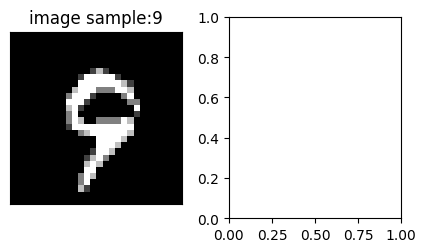

In [10]:
# plot_image(x, y, 'image sample')


In [15]:

# 构建网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# 进行网络的初始化
net = Net().to("cuda")
# 定义优化器
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# 初始化数组存储loss数值便于绘图
train_loss =[]

# 对数据集迭代
for epoch in range(1):
    # 对batch迭代
    for batch_idx, (x, y) in enumerate(train_loader):
      if batch_idx > 1e4: break
      # x:[b,1,28,28],y:[512]
      # [b, 784]
      x = x.view(x.size(0), 28*28).to("cuda")
      # [b, 10]
      out = net(x)
      y_onehot = one_hot(y).to("cuda")
      # loss=mse(out, y_onehot) 计算loss数值
      loss = F.mse_loss(out, y_onehot)
      # 将梯度置零操作
      optimizer.zero_grad()
      # 反向传播
      loss.backward()
      # 更新权重值
      optimizer.step()
      # 累加loss值
      train_loss.append(loss.item())
      # 每十个batch进行loss值打印
      if batch_idx % 10 ==0:
          print(epoch, batch_idx, loss.item())

# # 绘制loss曲线
# plot_curve(train_loss)

# # 进行测试
# total_correct = 0
# for x, y in test_loader:
#     x = x.view(x.size(0), 28*28)
#     out = net(x)
#     # out[b, 10], pred[b]
#     pred = out.argmax(dim=1)
#     correct = pred.eq(y).sum().float()
#     totol_correct += correct

# total_num = len(test_loader.dataset)
# acc = total_correct / total_num
# print('test acc:', acc)

# # 进行样例打印
# x, y = next(iter(test_loader))
# out = net(x.view(x.size(0), 28*28))
# pred = out.argmax(dim=1)
# plot_image(x, pred, 'test')

0 0 0.1168004646897316
0 10 0.04757364094257355
0 20 0.13495834171772003
0 30 0.1425168514251709
0 40 0.10365035384893417
0 50 0.09847479313611984
0 60 0.096549853682518
0 70 0.07275830954313278
0 80 0.10660126060247421
0 90 0.12021558731794357
0 100 0.07760921865701675
0 110 0.0965314507484436
0 120 0.11163824051618576
0 130 0.10442578047513962
0 140 0.07549736648797989
0 150 0.11839145421981812
0 160 0.0702194795012474
0 170 0.10788489878177643
0 180 0.08169298619031906
0 190 0.0954233705997467
0 200 0.10350115597248077
0 210 0.12605732679367065
0 220 0.09234599024057388
0 230 0.09036607295274734
0 240 0.10201163589954376
0 250 0.13261544704437256
0 260 0.11026287078857422
0 270 0.11211691051721573
0 280 0.13782738149166107
0 290 0.102610282599926
0 300 0.08393917977809906
0 310 0.10111068934202194
0 320 0.11114108562469482
0 330 0.08721322566270828
0 340 0.09845591336488724
0 350 0.10278737545013428
0 360 0.10239312797784805
0 370 0.06274015456438065
0 380 0.06713701784610748
0 390 

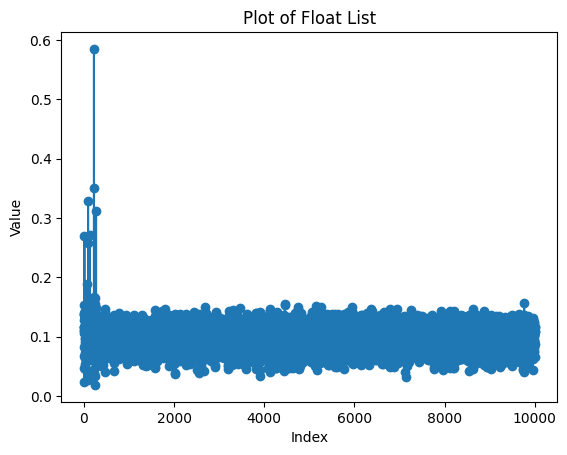

In [16]:
# 获取索引
indices = list(range(len(train_loss)))

# 绘制数据
# for i in range(len(loss_lists)):
plt.plot(indices, train_loss, marker='o')

# 添加标题和标签
plt.title('Plot of Float List')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图形
plt.show()
#

In [19]:
!nvidia-smi

Fri Jan 10 06:02:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0              31W /  70W |    167MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--